# Lecture 2: Present Value Relations I

## MIT 15.401 — Finance Theory I (Prof. Andrew Lo)

---

**Video:** [MIT OCW — Part I of Present Value Relations](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/present-value-relations/)

**Readings:** Brealey, Myers, and Allen — Chapters 2–3

---

This notebook covers **Session 2** — arguably the most foundational lecture in the entire course. It develops the **Present Value (PV) operator**, the single most important tool in all of finance. Every valuation problem ultimately reduces to a present value calculation.

We cover the definition of an asset as a sequence of cash flows, the time value of money, the NPV rule, and the special cash flow patterns (perpetuities and annuities) that appear throughout finance.

## Table of Contents

1. [Cash Flows and the Definition of an Asset](#1-cashflows)
2. [The Present Value Operator](#2-pv-operator)
3. [The Time Value of Money](#3-time-value)
4. [Net Present Value and the NPV Rule](#4-npv)
5. [Special Cash Flows: The Perpetuity](#5-perpetuity)
6. [Special Cash Flows: The Growing Perpetuity](#6-growing-perpetuity)
7. [Special Cash Flows: The Annuity](#7-annuity)
8. [Compounding Conventions](#8-compounding)
9. [Exercises](#9-exercises)

In [3]:
# ============================================================
# Setup
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import display, Markdown

plt.rcParams.update({
    'figure.figsize': (10, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'lines.linewidth': 2,
})
print("Libraries loaded successfully.")

Libraries loaded successfully.


---

<a id='1-cashflows'></a>
## 1. Cash Flows and the Definition of an Asset

> **An asset is any sequence of cash flows.**

| Example | Cash Flow Sequence |
|---------|-------------------|
| A bond | Fixed coupon payments + face value at maturity |
| A stock | Stream of uncertain future dividends |
| A business | Net cash flows from operations |
| A rental property | Monthly rent payments minus expenses |
| Your career | Lifetime stream of salary income |

Formally: $\text{Asset} \equiv \{CF_0, CF_1, CF_2, \ldots, CF_T\}$

### The Currency Analogy

Cash flows at different points in time are like cash in **different currencies**. The **discount rate** is the exchange rate that converts future dollars into present dollars — a single **numéraire** (dollars at time 0).

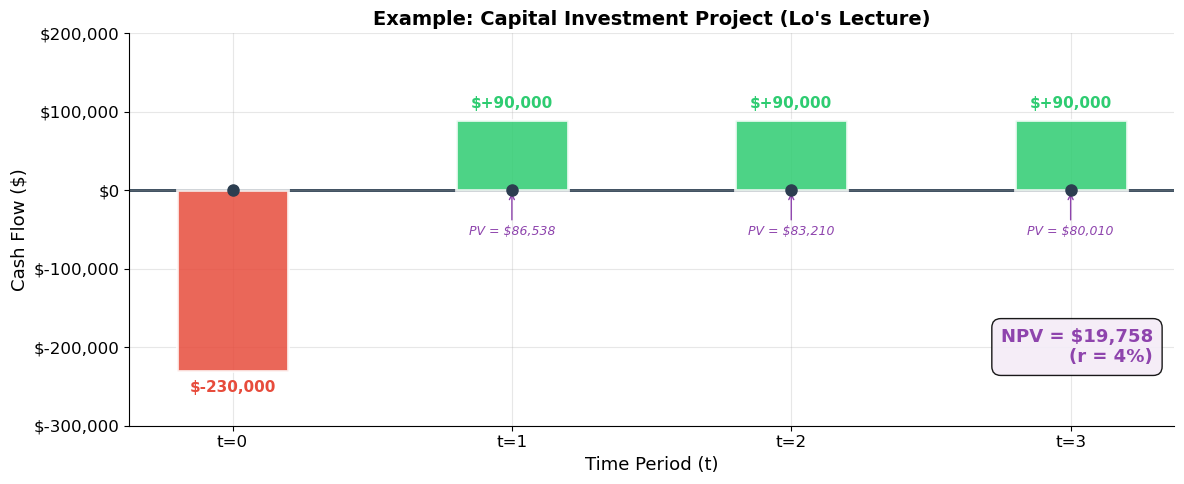

In [44]:
# ============================================================
# Cash Flow Timeline Visualization
# ============================================================

def plot_cashflow_timeline(cashflows, title="Cash Flow Timeline", discount_rate=None):
    """Visualize cash flows on a timeline, optionally showing PVs."""
    times = sorted(cashflows.keys())
    cfs = [cashflows[t] for t in times]
    max_abs = max(abs(c) for c in cfs)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axhline(y=0, color='#2c3e50', linewidth=2, zorder=1)
    
    for t, cf in zip(times, cfs):
        color = '#2ecc71' if cf >= 0 else '#e74c3c'
        ax.bar(t, cf, width=0.4, color=color, alpha=0.85, edgecolor='white', linewidth=2, zorder=2)
        offset = 0.05 * max_abs * (1 if cf >= 0 else -1)
        ax.text(t, cf + offset, f'${cf:+,.0f}', ha='center',
                va='bottom' if cf >= 0 else 'top', fontsize=11, fontweight='bold', color=color)
    
    if discount_rate is not None:
        pvs = [cf / (1 + discount_rate)**t for t, cf in zip(times, cfs)]
        for t, cf, pv in zip(times, cfs, pvs):
            if t > 0:
                ax.annotate(f'PV = ${pv:,.0f}', xy=(t, 0),
                           xytext=(t, -0.25 * max_abs), fontsize=9, ha='center',
                           color='#8e44ad', style='italic',
                           arrowprops=dict(arrowstyle='->', color='#8e44ad', lw=1))
        npv = sum(pvs)
        ax.text(0.98, 0.25, f'NPV = ${npv:,.0f}\n(r = {discount_rate:.0%})',
                transform=ax.transAxes, ha='right', va='top', fontsize=13,
                fontweight='bold', color='#8e44ad',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#f4ecf7', alpha=0.9))
    
    for t in times:
        ax.plot(t, 0, 'o', color='#2c3e50', markersize=8, zorder=3)
    
    ax.set_xlabel('Time Period (t)', fontsize=13)
    ax.set_ylabel('Cash Flow ($)', fontsize=13)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(times)
    ax.set_xticklabels([f't={t}' for t in times])
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    ax.set_ylim(-300000,200000)
    plt.tight_layout()
    plt.show()


# Lo's lecture example
plot_cashflow_timeline({0: -230000, 1: 90000, 2: 90000, 3: 90000},
                       title="Example: Capital Investment Project (Lo's Lecture)",
                       discount_rate=0.04)

---

<a id='2-pv-operator'></a>
## 2. The Present Value Operator

**Forward (compounding):** $FV = PV \times (1+r)^n$

**Backward (discounting):** $PV = FV / (1+r)^n$

### Key Properties

1. **Linearity:** $PV(CF_A + CF_B) = PV(CF_A) + PV(CF_B)$
2. **Only relative time matters:** $V_m = V_n \times (1 + r)^{m - n}$
3. **Discount factor < 1** for $r > 0$

### Assumptions (to be relaxed later)

- Cash flows and rates are known with **certainty**
- **No transaction costs**
- **Constant** discount rate

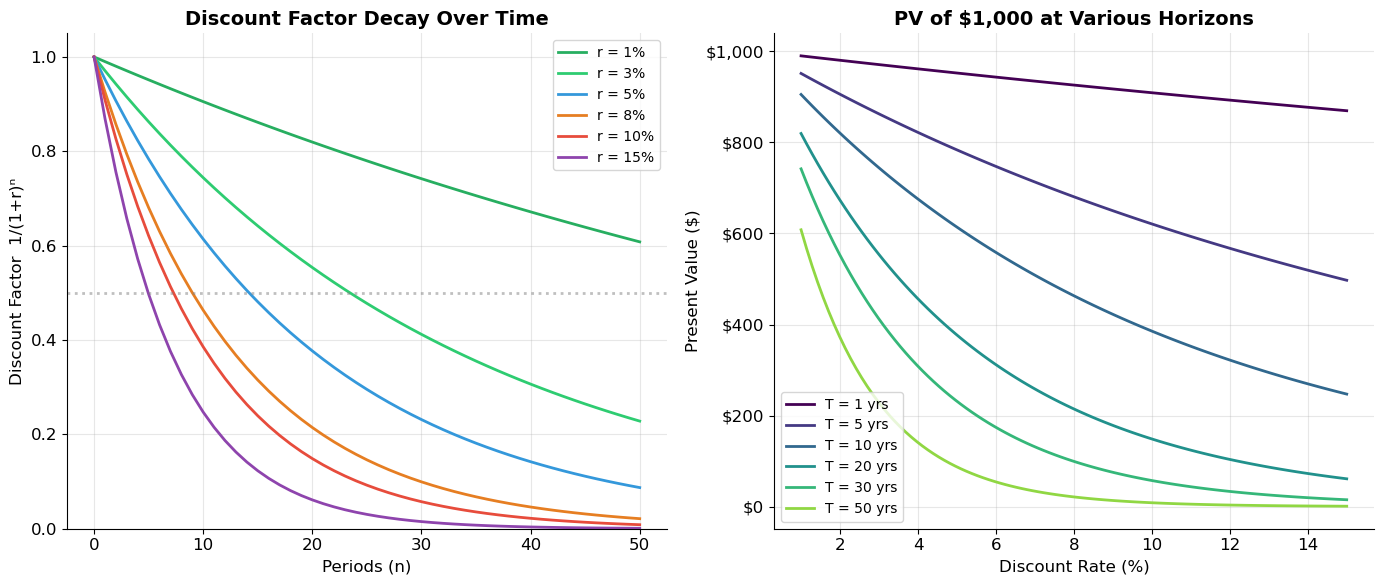

In [7]:
# ============================================================
# Discount Factor Decay
# ============================================================
periods = np.arange(0, 51)
rates = [0.01, 0.03, 0.05, 0.08, 0.10, 0.15]
colors = ['#27ae60', '#2ecc71', '#3498db', '#e67e22', '#e74c3c', '#8e44ad']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for r, color in zip(rates, colors):
    ax1.plot(periods, 1 / (1 + r)**periods, label=f'r = {r:.0%}', color=color, linewidth=2)

ax1.set_xlabel('Periods (n)')
ax1.set_ylabel('Discount Factor  1/(1+r)ⁿ')
ax1.set_title('Discount Factor Decay Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1.05)
ax1.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)

horizons = [1, 5, 10, 20, 30, 50]
rate_range = np.linspace(0.01, 0.15, 100)
cmap = plt.cm.viridis
for i, T in enumerate(horizons):
    ax2.plot(rate_range * 100, 1000 / (1 + rate_range)**T,
            label=f'T = {T} yrs', color=cmap(i / len(horizons)), linewidth=2)

ax2.set_xlabel('Discount Rate (%)')
ax2.set_ylabel('Present Value ($)')
ax2.set_title('PV of $1,000 at Various Horizons', fontsize=14, fontweight='bold')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

---

<a id='3-time-value'></a>
## 3. The Time Value of Money

A dollar today > a dollar tomorrow. Three reasons: **opportunity cost**, **impatience**, **inflation**.

$$\boxed{FV_n = PV \times (1 + r)^n} \qquad \boxed{PV = \frac{FV_n}{(1 + r)^n}}$$

---

<a id='4-npv'></a>
## 4. Net Present Value and the NPV Rule

$$\boxed{NPV = \sum_{t=0}^{T} \frac{CF_t}{(1+r)^t}}$$

$$\boxed{\text{Accept a project if and only if } NPV > 0}$$

In [10]:
# ============================================================
# NPV Calculation — Lo's Worked Example
# ============================================================

def compute_npv(cashflows, rate):
    """Compute NPV of a cash flow sequence."""
    return sum(cf / (1 + rate)**t for t, cf in enumerate(cashflows))

cashflows = [-230_000, 90_000, 90_000, 90_000]
r = 0.04

print("=" * 65)
print("NPV CALCULATION — Lo's Capital Investment Example")
print("=" * 65)
for t, cf in enumerate(cashflows):
    df = 1 / (1 + r)**t
    pv = cf * df
    print(f"  t={t}:  CF = ${cf:>10,.0f}  ×  1/(1.04)^{t} = {df:.6f}  →  PV = ${pv:>10,.2f}")
print("-" * 65)
npv = compute_npv(cashflows, r)
print(f"  NPV = ${npv:,.2f}")
print(f"  Decision: {'✅ ACCEPT' if npv > 0 else '❌ REJECT'}")

NPV CALCULATION — Lo's Capital Investment Example
  t=0:  CF = $  -230,000  ×  1/(1.04)^0 = 1.000000  →  PV = $-230,000.00
  t=1:  CF = $    90,000  ×  1/(1.04)^1 = 0.961538  →  PV = $ 86,538.46
  t=2:  CF = $    90,000  ×  1/(1.04)^2 = 0.924556  →  PV = $ 83,210.06
  t=3:  CF = $    90,000  ×  1/(1.04)^3 = 0.888996  →  PV = $ 80,009.67
-----------------------------------------------------------------
  NPV = $19,758.19
  Decision: ✅ ACCEPT


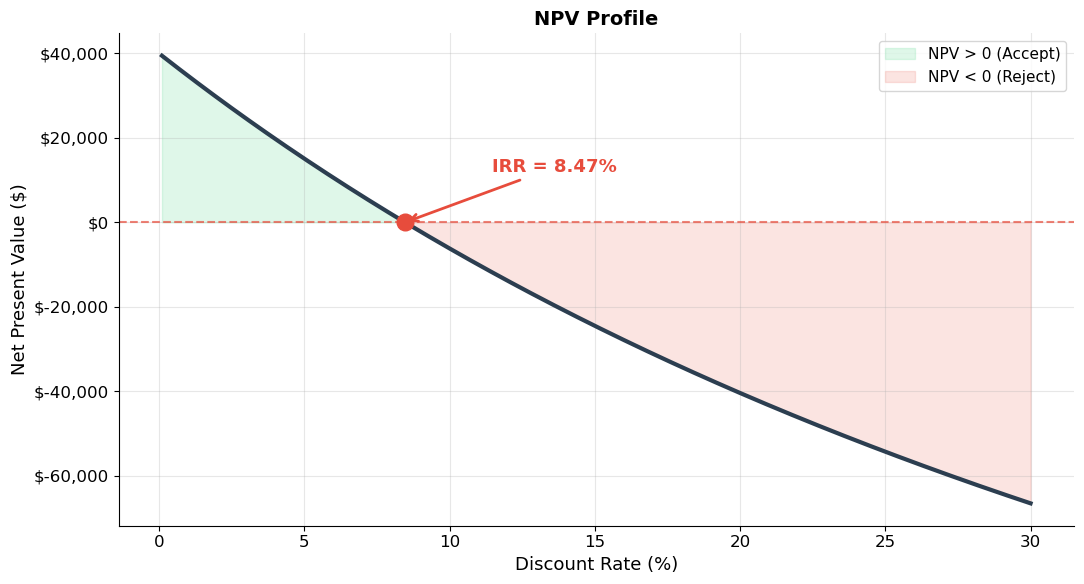

In [11]:
# ============================================================
# NPV Profile — NPV as a function of discount rate
# ============================================================
# ▶ MODIFY CASH FLOWS HERE AND RE-RUN
cashflows = [-230_000, 90_000, 90_000, 90_000]
# ============================================================

rates = np.linspace(0.001, 0.30, 300)
npvs = [compute_npv(cashflows, r) for r in rates]

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(rates * 100, npvs, color='#2c3e50', linewidth=3)
ax.axhline(y=0, color='#e74c3c', linewidth=1.5, linestyle='--', alpha=0.7)
ax.fill_between(rates * 100, npvs, 0, where=np.array(npvs) > 0, alpha=0.15, color='#2ecc71', label='NPV > 0 (Accept)')
ax.fill_between(rates * 100, npvs, 0, where=np.array(npvs) < 0, alpha=0.15, color='#e74c3c', label='NPV < 0 (Reject)')

# Find IRR
for i in range(len(npvs) - 1):
    if npvs[i] * npvs[i+1] < 0:
        irr = rates[i] + (rates[i+1] - rates[i]) * npvs[i] / (npvs[i] - npvs[i+1])
        ax.plot(irr * 100, 0, 'o', color='#e74c3c', markersize=12, zorder=5)
        ax.annotate(f'IRR = {irr:.2%}', xy=(irr*100, 0), xytext=(irr*100 + 3, max(npvs)*0.3),
                   fontsize=13, fontweight='bold', color='#e74c3c',
                   arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=2))
        break

ax.set_xlabel('Discount Rate (%)', fontsize=13)
ax.set_ylabel('Net Present Value ($)', fontsize=13)
ax.set_title('NPV Profile', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

---

<a id='5-perpetuity'></a>
## 5. Special Cash Flows: The Perpetuity

A perpetuity pays $C$ every period, **forever**. The geometric series gives:

$$\boxed{PV_{\text{perpetuity}} = \frac{C}{r}}$$

**Intuition:** Depositing $C/r$ at rate $r$ earns $C$ per year forever without touching principal.

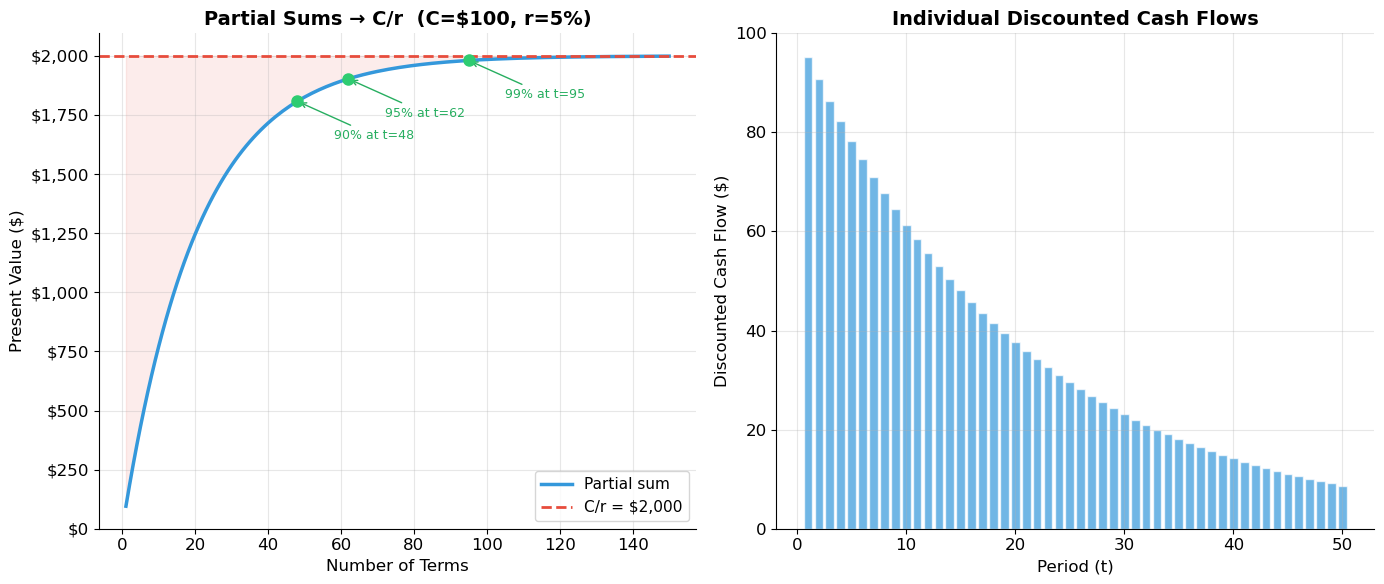

Exact PV = C/r = 100/0.05 = $2,000.00


In [13]:
# ============================================================
# Perpetuity: Partial Sums Converging to C/r
# ============================================================
# ▶ MODIFY AND RE-RUN
C = 100    # Annual payment
r = 0.05   # Discount rate
# ============================================================

exact_pv = C / r
max_terms = 150
terms = np.arange(1, max_terms + 1)
partial_sums = np.cumsum([C / (1 + r)**t for t in terms])
pct_captured = partial_sums / exact_pv * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(terms, partial_sums, color='#3498db', linewidth=2.5, label='Partial sum')
ax1.axhline(y=exact_pv, color='#e74c3c', linewidth=2, linestyle='--', label=f'C/r = ${exact_pv:,.0f}')
ax1.fill_between(terms, partial_sums, exact_pv, alpha=0.1, color='#e74c3c')

for pct_target in [90, 95, 99]:
    idx = np.argmax(pct_captured >= pct_target)
    ax1.plot(terms[idx], partial_sums[idx], 'o', color='#2ecc71', markersize=8, zorder=5)
    ax1.annotate(f'{pct_target}% at t={terms[idx]}', xy=(terms[idx], partial_sums[idx]),
                xytext=(terms[idx]+10, partial_sums[idx] - exact_pv*0.08), fontsize=9, color='#27ae60',
                arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1))

ax1.set_xlabel('Number of Terms')
ax1.set_ylabel('Present Value ($)')
ax1.set_title(f'Partial Sums → C/r  (C=${C}, r={r:.0%})', fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.legend(fontsize=11)

dcfs = [C / (1 + r)**t for t in range(1, 51)]
ax2.bar(range(1, 51), dcfs, color='#3498db', alpha=0.7, edgecolor='white')
ax2.set_xlabel('Period (t)')
ax2.set_ylabel('Discounted Cash Flow ($)')
ax2.set_title('Individual Discounted Cash Flows', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
print(f"Exact PV = C/r = {C}/{r} = ${exact_pv:,.2f}")

---

<a id='6-growing-perpetuity'></a>
## 6. Special Cash Flows: The Growing Perpetuity

Cash flows grow at constant rate $g$: $C, C(1+g), C(1+g)^2, \ldots$

$$\boxed{PV_{\text{growing perpetuity}} = \frac{C}{r - g} \qquad (g < r)}$$

This is the foundation of the **Gordon Growth Model** for stocks: $P_0 = D_1 / (r_e - g)$

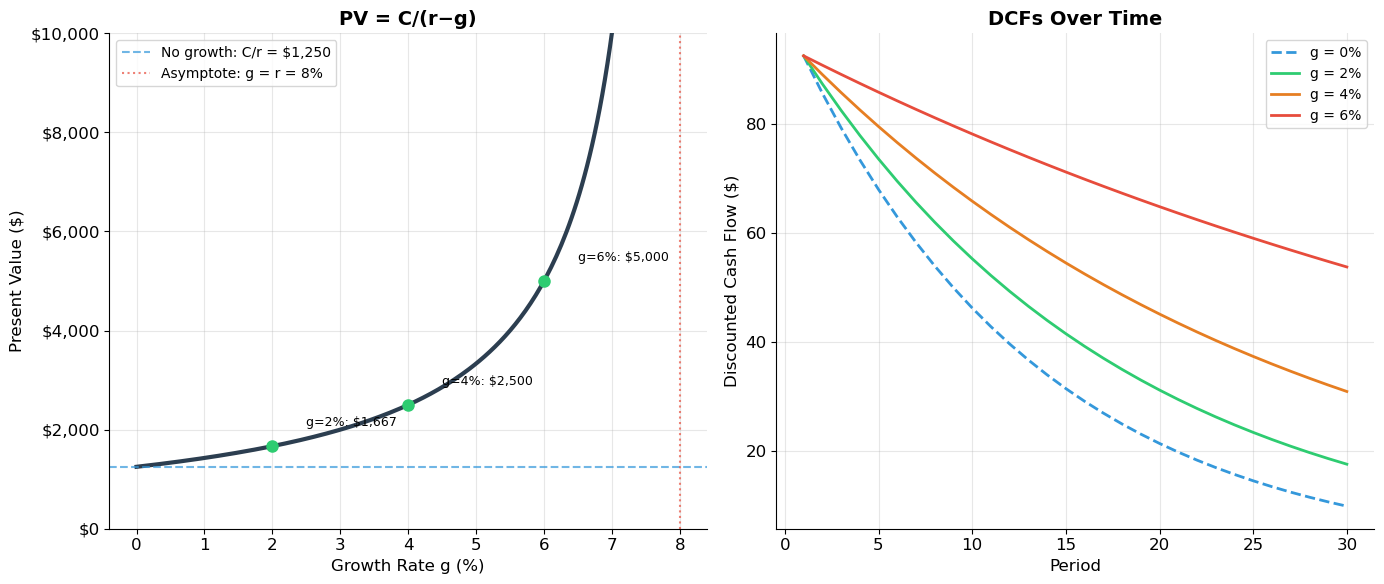

In [15]:
# ============================================================
# Growing Perpetuity: Sensitivity to Growth Rate
# ============================================================
# ▶ MODIFY AND RE-RUN
C = 100
r = 0.08
# ============================================================

g_values = np.linspace(0, r - 0.005, 200)
pv_values = C / (r - g_values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(g_values * 100, pv_values, color='#2c3e50', linewidth=3)
ax1.axhline(y=C/r, color='#3498db', linewidth=1.5, linestyle='--', label=f'No growth: C/r = ${C/r:,.0f}', alpha=0.7)
ax1.axvline(x=r*100, color='#e74c3c', linewidth=1.5, linestyle=':', label=f'Asymptote: g = r = {r:.0%}', alpha=0.7)
for g_mark in [0.02, 0.04, 0.06]:
    if g_mark < r:
        pv_mark = C / (r - g_mark)
        ax1.plot(g_mark*100, pv_mark, 'o', color='#2ecc71', markersize=8, zorder=5)
        ax1.annotate(f'g={g_mark:.0%}: ${pv_mark:,.0f}', xy=(g_mark*100, pv_mark),
                    xytext=(g_mark*100+0.5, pv_mark + max(pv_values)*0.02), fontsize=9)

ax1.set_xlabel('Growth Rate g (%)')
ax1.set_ylabel('Present Value ($)')
ax1.set_title('PV = C/(r−g)', fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.set_ylim(0, min(max(pv_values)*1.1, C/r*8))
ax1.legend(fontsize=10)

periods = np.arange(1, 31)
for g, color, ls in [(0, '#3498db', '--'), (0.02, '#2ecc71', '-'), (0.04, '#e67e22', '-'), (0.06, '#e74c3c', '-')]:
    if g < r:
        ax2.plot(periods, C*(1+g)**(periods-1) / (1+r)**periods, color=color, linewidth=2, linestyle=ls, label=f'g = {g:.0%}')
ax2.set_xlabel('Period')
ax2.set_ylabel('Discounted Cash Flow ($)')
ax2.set_title('DCFs Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

---

<a id='7-annuity'></a>
## 7. Special Cash Flows: The Annuity

An annuity pays $C$ for $T$ periods. Using the **perpetuity difference trick**:

$$\text{Annuity}(1 \to T) = \text{Perpetuity}_{t=1} - \text{Perpetuity}_{t=T+1}$$

$$\boxed{PV_{\text{annuity}} = C \times \underbrace{\frac{1 - (1+r)^{-T}}{r}}_{A(r,T)}}$$

**Future value:** $FV = C \times \frac{(1+r)^T - 1}{r}$

In [17]:
# ============================================================
# Core PV Functions — Reusable Toolkit
# ============================================================

def pv_perpetuity(C, r):
    return C / r

def pv_growing_perpetuity(C, r, g):
    return C / (r - g) if r > g else float('inf')

def annuity_discount_factor(r, T):
    return (1 - (1 + r)**(-T)) / r if r != 0 else T

def pv_annuity(C, r, T):
    return C * annuity_discount_factor(r, T)

def fv_annuity(C, r, T):
    return C * ((1 + r)**T - 1) / r if r != 0 else C * T

def pv_growing_annuity(C, r, g, T):
    if abs(r - g) < 1e-10:
        return C * T / (1 + r)
    return C * (1 - ((1 + g) / (1 + r))**T) / (r - g)

# Verification
print("PV Formula Verification")
print("=" * 55)
print(f"Perpetuity ($100/yr, r=5%):          ${pv_perpetuity(100, 0.05):>10,.2f}")
print(f"Growing Perp ($100/yr, r=8%, g=3%):  ${pv_growing_perpetuity(100, 0.08, 0.03):>10,.2f}")
print(f"Annuity ($100/yr, r=5%, T=20):       ${pv_annuity(100, 0.05, 20):>10,.2f}")
print(f"ADF(5%, 20) =                        {annuity_discount_factor(0.05, 20):>10.6f}")

print(f"\nConvergence: annuity → perpetuity as T → ∞ (C=$100, r=5%):")
pv_p = pv_perpetuity(100, 0.05)
for T in [10, 20, 50, 100, 500]:
    pv_a = pv_annuity(100, 0.05, T)
    print(f"  T={T:>4d}: ${pv_a:>10,.2f}  ({pv_a/pv_p:.4%} of perpetuity)")

PV Formula Verification
Perpetuity ($100/yr, r=5%):          $  2,000.00
Growing Perp ($100/yr, r=8%, g=3%):  $  2,000.00
Annuity ($100/yr, r=5%, T=20):       $  1,246.22
ADF(5%, 20) =                         12.462210

Convergence: annuity → perpetuity as T → ∞ (C=$100, r=5%):
  T=  10: $    772.17  (38.6087% of perpetuity)
  T=  20: $  1,246.22  (62.3111% of perpetuity)
  T=  50: $  1,825.59  (91.2796% of perpetuity)
  T= 100: $  1,984.79  (99.2396% of perpetuity)
  T= 500: $  2,000.00  (100.0000% of perpetuity)


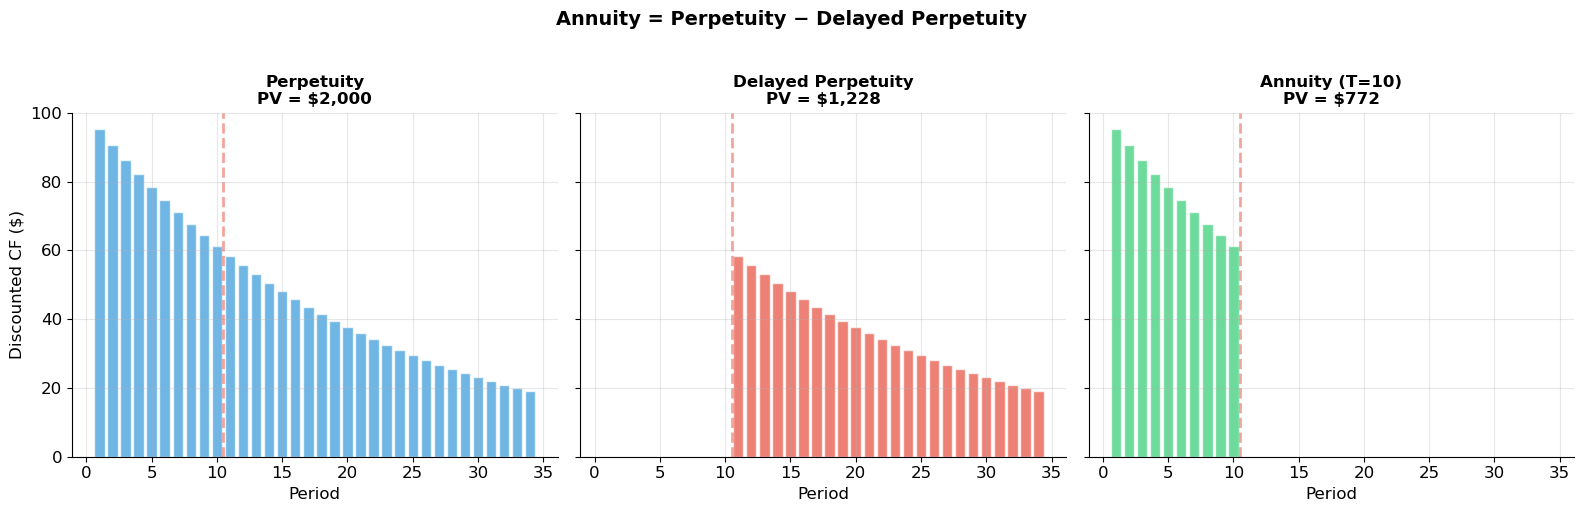

In [18]:
# ============================================================
# Annuity = Perpetuity − Delayed Perpetuity
# ============================================================
# ▶ MODIFY AND RE-RUN
C, r, T = 100, 0.05, 10
# ============================================================

periods = np.arange(1, T + 25)
perp1_dcf = np.array([C / (1 + r)**t for t in periods])
perp2_dcf = np.array([C / (1 + r)**t if t > T else 0 for t in periods])
annuity_dcf = np.array([C / (1 + r)**t if t <= T else 0 for t in periods])

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

axes[0].bar(periods, perp1_dcf, color='#3498db', alpha=0.7, edgecolor='white')
axes[0].set_title(f'Perpetuity\nPV = ${C/r:,.0f}', fontsize=12, fontweight='bold')
axes[0].axvline(x=T+0.5, color='#e74c3c', linestyle='--', alpha=0.5)

pv_del = (C/r) / (1+r)**T
axes[1].bar(periods, perp2_dcf, color='#e74c3c', alpha=0.7, edgecolor='white')
axes[1].set_title(f'Delayed Perpetuity\nPV = ${pv_del:,.0f}', fontsize=12, fontweight='bold')
axes[1].axvline(x=T+0.5, color='#e74c3c', linestyle='--', alpha=0.5)

pv_ann = pv_annuity(C, r, T)
axes[2].bar(periods, annuity_dcf, color='#2ecc71', alpha=0.7, edgecolor='white')
axes[2].set_title(f'Annuity (T={T})\nPV = ${pv_ann:,.0f}', fontsize=12, fontweight='bold')
axes[2].axvline(x=T+0.5, color='#e74c3c', linestyle='--', alpha=0.5)

for ax in axes:
    ax.set_xlabel('Period')
axes[0].set_ylabel('Discounted CF ($)')
fig.suptitle(f'Annuity = Perpetuity − Delayed Perpetuity', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

MORTGAGE ANALYSIS
Loan amount:         $     400,000
Rate:                       6.00%
Term:                       30 years
Monthly payment:     $    2,398.20
Total payments:      $     863,353
Total interest:      $     463,353
Interest/Principal:        115.8%


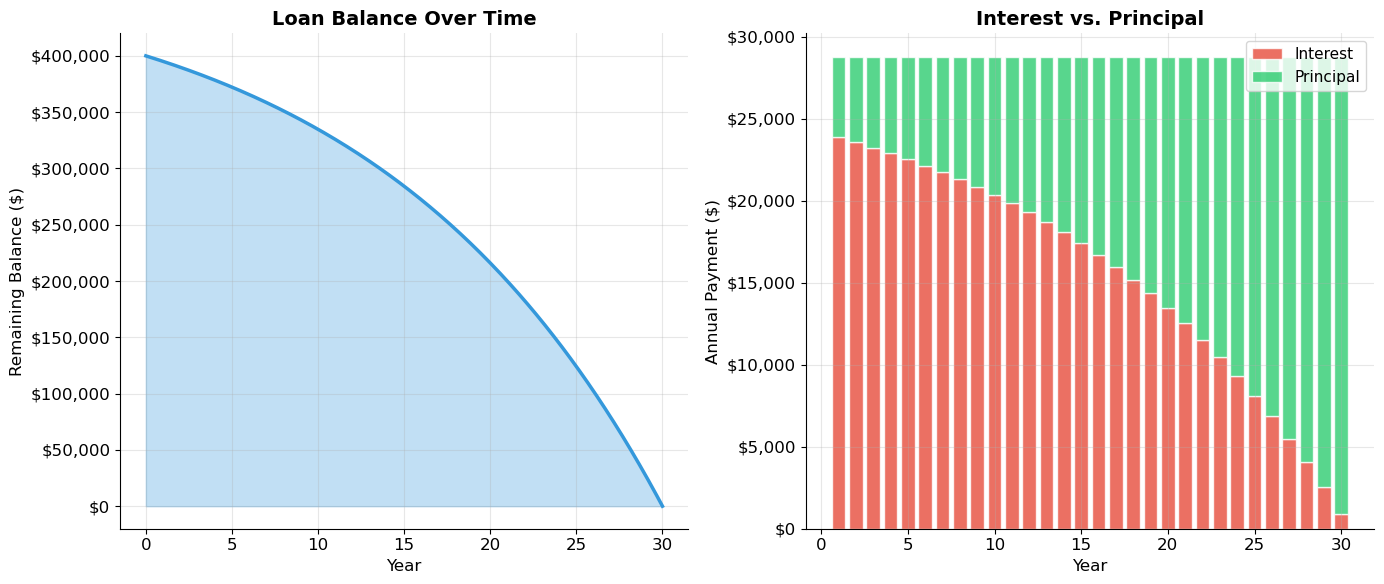

In [19]:
# ============================================================
# Application: Mortgage Amortization
# ============================================================
# ▶ MODIFY AND RE-RUN
principal = 400_000
annual_rate = 0.06
years = 30
# ============================================================

monthly_rate = annual_rate / 12
n_payments = years * 12
monthly_payment = principal * monthly_rate / (1 - (1 + monthly_rate)**(-n_payments))

balance = principal
balances, interest_parts, principal_parts = [principal], [], []
total_interest = 0

for month in range(1, n_payments + 1):
    interest = balance * monthly_rate
    ppay = monthly_payment - interest
    balance -= ppay
    balances.append(max(balance, 0))
    interest_parts.append(interest)
    principal_parts.append(ppay)
    total_interest += interest

print("=" * 55)
print("MORTGAGE ANALYSIS")
print("=" * 55)
print(f"Loan amount:         ${principal:>12,.0f}")
print(f"Rate:                 {annual_rate:>11.2%}")
print(f"Term:                 {years:>8} years")
print(f"Monthly payment:     ${monthly_payment:>12,.2f}")
print(f"Total payments:      ${monthly_payment * n_payments:>12,.0f}")
print(f"Total interest:      ${total_interest:>12,.0f}")
print(f"Interest/Principal:   {total_interest/principal:>11.1%}")

annual_int = [sum(interest_parts[i*12:(i+1)*12]) for i in range(years)]
annual_prin = [sum(principal_parts[i*12:(i+1)*12]) for i in range(years)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

months = np.arange(0, n_payments + 1)
ax1.fill_between(months/12, balances, alpha=0.3, color='#3498db')
ax1.plot(months/12, balances, color='#3498db', linewidth=2.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('Remaining Balance ($)')
ax1.set_title('Loan Balance Over Time', fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

yr = np.arange(1, years + 1)
ax2.bar(yr, annual_int, color='#e74c3c', alpha=0.8, label='Interest', edgecolor='white')
ax2.bar(yr, annual_prin, bottom=annual_int, color='#2ecc71', alpha=0.8, label='Principal', edgecolor='white')
ax2.set_xlabel('Year')
ax2.set_ylabel('Annual Payment ($)')
ax2.set_title('Interest vs. Principal', fontsize=14, fontweight='bold')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

---

<a id='8-compounding'></a>
## 8. Compounding Conventions

$$\boxed{r_{\text{EAR}} = \left(1 + \frac{r}{n}\right)^n - 1}$$

Continuous compounding ($n \to \infty$): $\;r_{\text{EAR}} = e^r - 1$, $\;FV = PV \cdot e^{rT}$

Stated (nominal) annual rate: 10.00%
Compounding         n           EAR   vs stated
-------------------------------------------------------
Annual              1    10.000000%  +0.000000%
Semi-annual         2    10.250000%  +0.250000%
Quarterly           4    10.381289%  +0.381289%
Monthly            12    10.471307%  +0.471307%
Weekly             52    10.506479%  +0.506479%
Daily             365    10.515578%  +0.515578%
Continuous          ∞    10.517092%  +0.517092%


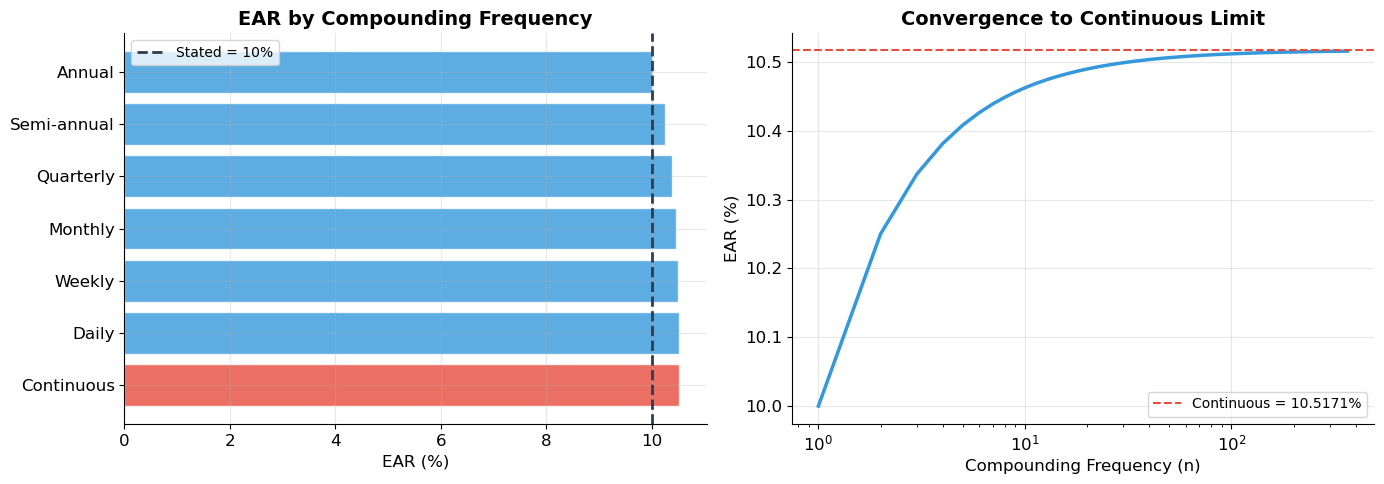

In [21]:
# ============================================================
# Compounding Frequency and Effective Annual Rate
# ============================================================
# ▶ MODIFY AND RE-RUN
stated_rate = 0.10
# ============================================================

frequencies = {'Annual': 1, 'Semi-annual': 2, 'Quarterly': 4,
               'Monthly': 12, 'Weekly': 52, 'Daily': 365}
continuous_ear = np.exp(stated_rate) - 1

print(f"Stated (nominal) annual rate: {stated_rate:.2%}")
print("=" * 55)
print(f"{'Compounding':15s} {'n':>5s}  {'EAR':>12s}  {'vs stated':>10s}")
print("-" * 55)

names, ears = [], []
for name, n in frequencies.items():
    ear = (1 + stated_rate / n)**n - 1
    print(f"{name:15s} {n:>5d}  {ear:>12.6%}  {ear - stated_rate:>+10.6%}")
    names.append(name)
    ears.append(ear)
print(f"{'Continuous':15s} {'∞':>5s}  {continuous_ear:>12.6%}  {continuous_ear - stated_rate:>+10.6%}")
names.append('Continuous')
ears.append(continuous_ear)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#3498db'] * len(names)
colors[-1] = '#e74c3c'
ax1.barh(names, [e*100 for e in ears], color=colors, alpha=0.8, edgecolor='white')
ax1.axvline(x=stated_rate*100, color='#2c3e50', linewidth=2, linestyle='--', label=f'Stated = {stated_rate:.0%}')
ax1.set_xlabel('EAR (%)')
ax1.set_title('EAR by Compounding Frequency', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.invert_yaxis()

n_range = np.arange(1, 366)
ax2.plot(n_range, ((1 + stated_rate/n_range)**n_range - 1)*100, color='#3498db', linewidth=2.5)
ax2.axhline(y=continuous_ear*100, color='#e74c3c', linewidth=1.5, linestyle='--', label=f'Continuous = {continuous_ear:.4%}')
ax2.set_xlabel('Compounding Frequency (n)')
ax2.set_ylabel('EAR (%)')
ax2.set_title('Convergence to Continuous Limit', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

---

## Summary of Key Formulas

| Formula | Expression | Conditions |
|---------|-----------|------------|
| **Future Value** | $FV = PV(1+r)^n$ | — |
| **Present Value** | $PV = FV/(1+r)^n$ | — |
| **NPV** | $\sum_{t=0}^{T} CF_t/(1+r)^t$ | Accept if NPV > 0 |
| **Perpetuity** | $PV = C/r$ | $r > 0$ |
| **Growing Perpetuity** | $PV = C/(r-g)$ | $r > g$ |
| **Annuity** | $PV = C \times [1-(1+r)^{-T}]/r$ | — |
| **Growing Annuity** | $PV = C \times [1-((1+g)/(1+r))^T]/(r-g)$ | $r \neq g$ |
| **EAR** | $(1+r/n)^n - 1$ | — |
| **Continuous** | $FV = PV \cdot e^{rT}$ | — |

---

<a id='9-exercises'></a>
## 9. Exercises

### Exercise 1: NPV Investment Decision

A property costs \$500,000 today, needs \$20,000 renovation at year 1, generates \$60,000/year rental (years 2–10), and sells for \$550,000 at year 10. Discount rate = 7%.

**(a)** Calculate NPV. Should you invest?  
**(b)** Find the IRR numerically.  
**(c)** What is the maximum purchase price to break even?

In [24]:
# Exercise 1 — Workspace
# cashflows = [-500000, -20000] + [60000]*8 + [60000 + 550000]
# npv = compute_npv(cashflows, 0.07)
# print(f"NPV = ${npv:,.2f}")

# from scipy.optimize import brentq
# irr = brentq(lambda r: compute_npv(cashflows, r), 0.001, 0.50)
# print(f"IRR = {irr:.4%}")

### Exercise 2: Perpetuities and Annuities

**(a)** A consol pays £4/year. Price at 3.5% yield? At 5%? Percentage loss?  
**(b)** Deposit \$5,000/yr for 35 years at 7%. FV at retirement? PV today?  
**(c)** Withdraw fixed amount for 25 years at 5%. Maximum annual withdrawal?

In [26]:
# Exercise 2 — Workspace
# (a)
# print(f"Price at 3.5%: £{4/0.035:,.2f}")
# print(f"Price at 5.0%: £{4/0.05:,.2f}")

# (b)
# print(f"FV: ${fv_annuity(5000, 0.07, 35):,.2f}")

# (c)
# nest_egg = fv_annuity(5000, 0.07, 35)
# withdrawal = nest_egg / annuity_discount_factor(0.05, 25)
# print(f"Annual withdrawal: ${withdrawal:,.2f}")

### Exercise 3: Compounding

**(a)** Bank A: 4.8% monthly. Bank B: 4.85% semi-annual. Which is better?  
**(b)** \$10,000 at 6% for 5 years: compare annual, quarterly, monthly, daily, continuous.  
**(c)** Zero-coupon bond: face \$1,000, price \$627, maturity 8 years. YTM under annual and continuous compounding?

In [28]:
# Exercise 3 — Workspace
# (a)
# ear_a = (1 + 0.048/12)**12 - 1
# ear_b = (1 + 0.0485/2)**2 - 1
# print(f"Bank A: {ear_a:.6%},  Bank B: {ear_b:.6%}")

# (c)
# ytm_annual = (1000/627)**(1/8) - 1
# ytm_cont = np.log(1000/627) / 8
# print(f"YTM annual: {ytm_annual:.4%},  continuous: {ytm_cont:.4%}")

---

## References

- **Brealey, R.A., Myers, S.C., and Allen, F.** *Principles of Corporate Finance*, Chapters 2–3.
- **MIT OCW 15.401:** [Present Value Relations](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/present-value-relations/)
- **Gordon, M.J.** (1959). "Dividends, Earnings, and Stock Prices." *Review of Economics and Statistics*, 41(2), 99–105.

---

*Next: **Session 3 — Present Value Relations II** — more NPV examples, growing annuity, inflation, real vs. nominal returns, and the Lehman Brothers leverage example.*